In [37]:
import tensorflow as tf
import numpy as np
from datetime import datetime as dt
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
def neuron_layer(X, n_neurons, name, activation = None, weights_regularizer = None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev = stddev)
        W = tf.get_variable("{}_weights".format(name), initializer = init, regularizer = weights_regularizer)
        b = tf.Variable(tf.zeros([n_neurons]), name = "biasses")
        z = tf.matmul(X, W) + b
        if activation == "relu":
            return tf.nn.relu(z)
        elif activation == "elu":
            return tf.nn.elu(z)
        else:
            return z

def predict_and_generate(path, n_sim, n_steps, beginning = 12.2):
    reset_graph()
    saver = tf.train.import_meta_graph(path + ".meta")
    X = tf.get_default_graph().get_tensor_by_name("X:0")
    outputs = tf.get_default_graph().get_tensor_by_name("network/outputs:0")
    t_instance = np.linspace(beginning, beginning + resolution * (n_steps + n_sim + 1), n_steps + n_sim + 2)
    t_instance_1 = np.linspace(beginning, beginning + resolution * (n_steps + 1), n_steps + 1)
    t_instance_2 = np.linspace(beginning + resolution * (n_steps + 1), beginning + resolution * (n_steps + n_sim + 1), n_sim + 1)

    with tf.Session() as sess:                          # not shown in the book
        saver.restore(sess, path)   # not shown
        X_new = time_series(np.array(t_instance_1[:-1].reshape(-1, n_steps, n_inputs)))
        y_pred = sess.run(outputs, feed_dict={X: X_new})
        X_extend = np.copy(X_new)
        y_pred_2 = np.empty([1, 0, 1])
        y_pred_1 = np.copy(y_pred)
        for i in range(n_sim):
            X_extend[:,0:n_steps - 1,:] = X_extend[:,1:n_steps,:]
            X_extend[:,n_steps - 1,:] = y_pred_1[:,n_steps-1,:]
            y_pred_1 = sess.run(outputs, feed_dict={X: X_extend})
            y_pred_2 = np.append(y_pred_2, y_pred_1[:,n_steps-1:,:],axis = 1)

    plt.title("Testing the model", fontsize=14)
    plt.plot(t_instance[1:-1], time_series(t_instance[1:-1]), "bo", markersize=10, label="instance")
    plt.plot(t_instance_1[1:], y_pred[0,:,0], "r.", markersize=10, label="predicted")
    plt.plot(t_instance_2[1:], y_pred_2[0,:,0], "y.", markersize=10, label="generated")
    plt.legend(loc="upper left")
    plt.xlabel("Time")

    plt.show()
    

In [15]:
reset_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape = [n_inputs, n_neurons], dtype = tf.float32))
Wy = tf.Variable(tf.random_normal(shape = [n_neurons, n_neurons], dtype = tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype = tf.float32))

Y0 = tf.tanh(tf.add(tf.matmul(X0, Wx), b))
Y1 = tf.tanh(tf.add(tf.add(tf.matmul(X1, Wx), tf.matmul(Y0, Wy)), b))

init= tf.global_variables_initializer()

X0_batch = np.array([[0,1,2],[3,4,5],[6,7,8],[9,0,1]])
X1_batch = np.array([[9,8,7],[0,0,0],[6,5,4],[3,2,1]])

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict = {X0 : X0_batch, X1 : X1_batch})
    
print(Y0_val)
print(Y1_val)

[[-0.0664006   0.9625767   0.68105793  0.7091854  -0.898216  ]
 [ 0.9977755  -0.719789   -0.9965761   0.9673924  -0.9998972 ]
 [ 0.99999774 -0.99898803 -0.9999989   0.9967762  -0.9999999 ]
 [ 1.         -1.         -1.         -0.99818915  0.9995087 ]]
[[ 1.         -1.         -1.          0.4020025  -0.9999998 ]
 [-0.12210419  0.62805265  0.9671843  -0.9937122  -0.2583937 ]
 [ 0.9999983  -0.9999994  -0.9999975  -0.85943305 -0.9999881 ]
 [ 0.99928284 -0.99999815 -0.9999058   0.9857963  -0.92205757]]


In [17]:
reset_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, [X0, X1], dtype=tf.float32)

Y0, Y1 = output_seqs

init= tf.global_variables_initializer()

X0_batch = np.array([[0,1,2],[3,4,5],[6,7,8],[9,0,1]])
X1_batch = np.array([[9,8,7],[0,0,0],[6,5,4],[3,2,1]])

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict = {X0 : X0_batch, X1 : X1_batch})
    
print(Y0_val)
print(Y1_val)

[[ 0.30741334 -0.32884315 -0.6542847  -0.9385059   0.52089024]
 [ 0.99122757 -0.9542541  -0.7518079  -0.9995208   0.9820235 ]
 [ 0.9999268  -0.99783254 -0.8247353  -0.9999963   0.99947774]
 [ 0.996771   -0.68750614  0.8419969   0.9303911   0.8120684 ]]
[[ 0.99998885 -0.99976057 -0.0667929  -0.9999803   0.99982214]
 [-0.6524943  -0.51520866 -0.37968948 -0.5922594  -0.08968379]
 [ 0.99862397 -0.99715203 -0.03308626 -0.9991566   0.9932902 ]
 [ 0.99681675 -0.9598194   0.39660627 -0.8307606   0.79671973]]


In [25]:
reset_graph()

n_steps = 2
n_inputs = 3
n_neurons = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs]) #m x 2 x 3
X_seqs = tf.unstack(tf.transpose(X, perm=[1,0,2])) #2 * (m x 3)

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, X_seqs, dtype=tf.float32) #2* (m x 5)
output = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2]) #m x 2 x 5

init= tf.global_variables_initializer()

X_batch = np.array([
        [[0,1,2],[9,8,7]],
        [[3,4,5],[0,0,0]],
        [[6,7,8],[6,5,4]],
        [[9,0,1],[3,2,1]]
    ])

with tf.Session() as sess:
    init.run()
    output_val = sess.run(output, feed_dict = {X : X_batch})
    
print(output_val)

[[[-0.45652324 -0.68064123  0.40938237  0.63104504 -0.45732826]
  [-0.9428799  -0.9998869   0.94055814  0.9999985  -0.9999997 ]]

 [[-0.8001535  -0.9921827   0.7817797   0.9971032  -0.9964609 ]
  [-0.637116    0.11300927  0.5798437   0.4310559  -0.6371699 ]]

 [[-0.93605185 -0.9998379   0.9308867   0.9999815  -0.99998295]
  [-0.9165386  -0.9945604   0.896054    0.99987197 -0.9999751 ]]

 [[ 0.9927369  -0.9981933  -0.55543643  0.9989031  -0.9953323 ]
  [-0.02746338 -0.73191994  0.7827872   0.9525682  -0.9781773 ]]]


In [28]:
reset_graph()

n_steps = 2
n_inputs = 3
n_neurons = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs]) #m x 2 x 3

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32) #m x 2 x 5

init= tf.global_variables_initializer()

X_batch = np.array([
        [[0,1,2],[9,8,7]],
        [[3,4,5],[0,0,0]],
        [[6,7,8],[6,5,4]],
        [[9,0,1],[3,2,1]]
    ])

with tf.Session() as sess:
    init.run()
    output_val = sess.run(output, feed_dict = {X : X_batch})
    
print(output_val)

[[[-0.85115266  0.87358344  0.5802911   0.8954789  -0.0557505 ]
  [-0.999996    0.99999577  0.9981815   1.          0.37679607]]

 [[-0.9983293   0.9992038   0.98071456  0.999985    0.25192663]
  [-0.7081804  -0.0772338  -0.85227895  0.5845349  -0.78780943]]

 [[-0.9999827   0.99999535  0.9992863   1.          0.5159072 ]
  [-0.9993956   0.9984095   0.83422637  0.99999976 -0.47325212]]

 [[ 0.87888587  0.07356028  0.97216916  0.9998546  -0.7351168 ]
  [-0.9134514   0.3600957   0.7624866   0.99817705  0.80142   ]]]


In [29]:
reset_graph()

n_steps = 2
n_inputs = 3
n_neurons = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs]) #m x 2 x 3
seq_length = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32, sequence_length=seq_length) #m x 2 x 5

init= tf.global_variables_initializer()

X_batch = np.array([
        [[0,1,2],[9,8,7]],
        [[3,4,5],[0,0,0]],
        [[6,7,8],[6,5,4]],
        [[9,0,1],[3,2,1]]
    ])

seq_length_batch = np.array([2, 1, 2, 2])

with tf.Session() as sess:
    init.run()
    output_val = sess.run(output, feed_dict = {X : X_batch, seq_length : seq_length_batch})
    
print(output_val)

[[[-0.9123188   0.16516446  0.5548655  -0.39159346  0.20846416]
  [-1.          0.956726    0.99831694  0.99970174  0.96518576]]

 [[-0.9998612   0.6702289   0.9723653   0.6631046   0.74457586]
  [ 0.          0.          0.          0.          0.        ]]

 [[-0.99999976  0.8967997   0.9986295   0.9647514   0.93662   ]
  [-0.9999526   0.9681953   0.96002865  0.98706263  0.85459226]]

 [[-0.96435434  0.99501586 -0.36150697  0.9983378   0.999497  ]
  [-0.9613586   0.9568762   0.7132288   0.97729224 -0.0958299 ]]]


In [43]:
reset_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

with tf.name_scope("network"):
    basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
    output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)
    logits = neuron_layer(states, n_outputs, "logits", activation = None, weights_regularizer = None)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy)
    
with tf.name_scope("trainer"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("performance_measures"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init= tf.global_variables_initializer()

saver = tf.train.Saver()

acc_train_summary = tf.summary.scalar('Train_accuracy', accuracy)
acc_test_summary = tf.summary.scalar('Test_accuracy', accuracy)

In [39]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/")
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [44]:
now = dt.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "./CH14/logs"
logdir = "{}/run-{}/".format(root_logdir, now)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        print("Alive {}".format(epoch))
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            if iteration % 10 == 0 :
                acc_train_str = acc_train_summary.eval(feed_dict = {X : X_batch, y : y_batch})
                acc_test_str = acc_test_summary.eval(feed_dict = {X: X_test, y: y_test})
                step = epoch * (mnist.train.num_examples // batch_size) + iteration
                file_writer.add_summary(acc_train_str, step)
                file_writer.add_summary(acc_test_str, step)
    save_path = saver.save(sess,"./CH14/models/mnist_rnn_final.ckpt")

Alive 0
Alive 1
Alive 2
Alive 3
Alive 4
Alive 5
Alive 6
Alive 7
Alive 8
Alive 9


# Time Series

## Multi-Layer RNN

In [9]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

In [10]:
reset_graph()

n_steps = 40
n_inputs = 1
n_neurons = 100
n_layers = 3
n_outputs = 1

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs], name = "X")
y = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

with tf.name_scope("network"):
    basic_layer = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu) for layer in range(n_layers)]
    ml_cell = tf.contrib.rnn.MultiRNNCell(basic_layer)
    rnn_output, states = tf.nn.dynamic_rnn(ml_cell, X, dtype=tf.float32)
    stacked_rnn_output = tf.reshape(rnn_output, [-1, n_neurons])
    stacked_output = neuron_layer(stacked_rnn_output, n_outputs, "FC", activation = None, weights_regularizer = None)
    outputs = tf.reshape(stacked_output, [-1, n_steps, n_outputs], name = "outputs")

with tf.name_scope("loss"):
    loss = tf.reduce_mean(tf.square(outputs - y))
    
with tf.name_scope("trainer"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)

init= tf.global_variables_initializer()

saver = tf.train.Saver()

MSE_summary = tf.summary.scalar('Train_MSE', loss)

In [11]:
now = dt.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "./CH14/logs"
logdir = "{}/run-{}/".format(root_logdir, now)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 10 == 0 :
            mse_train_str = MSE_summary.eval(feed_dict = {X : X_batch, y : y_batch})
            file_writer.add_summary(mse_train_str, iteration)
    save_path = saver.save(sess,"./CH14/models/time_series_rnn_final.ckpt")

INFO:tensorflow:Restoring parameters from ./CH14/models/time_series_rnn_final.ckpt


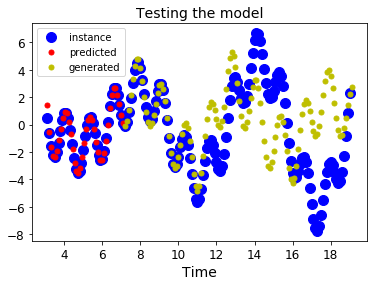

In [18]:
predict_and_generate("./CH14/models/time_series_rnn_final.ckpt", 120, n_steps, beginning = 3.)

## Creative RNN

In [19]:
reset_graph()

n_steps = 40
n_inputs = 1
n_neurons = 100
n_outputs = 1

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs], name = "X")
y = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

with tf.name_scope("network"):
    basic_layer = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
    rnn_output, states = tf.nn.dynamic_rnn(basic_layer, X, dtype=tf.float32)
    stacked_rnn_output = tf.reshape(rnn_output, [-1, n_neurons])
    stacked_output = tf.layers.dense(stacked_rnn_output, n_outputs)
    outputs = tf.reshape(stacked_output, [-1, n_steps, n_outputs], name = "outputs")

with tf.name_scope("loss"):
    loss = tf.reduce_mean(tf.square(outputs - y))
    
with tf.name_scope("trainer"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)


init= tf.global_variables_initializer()

saver = tf.train.Saver()

MSE_summary = tf.summary.scalar('Train_MSE', loss)

In [20]:
now = dt.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "./CH14/logs"
logdir = "{}/run-{}/".format(root_logdir, now)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 10 == 0 :
            mse_train_str = MSE_summary.eval(feed_dict = {X : X_batch, y : y_batch})
            file_writer.add_summary(mse_train_str, iteration)
    save_path = saver.save(sess,"./CH14/models/creative_time_series_rnn_final.ckpt")

INFO:tensorflow:Restoring parameters from ./CH14/models/creative_time_series_rnn_final.ckpt


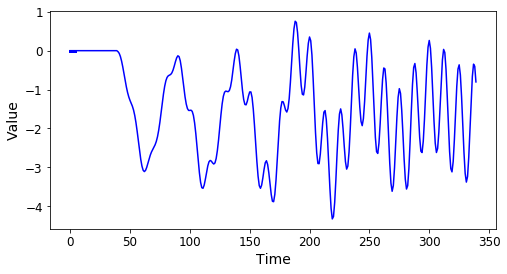

In [24]:
with tf.Session() as sess:                        # not shown in the book
    saver.restore(sess, "./CH14/models/creative_time_series_rnn_final.ckpt") # not shown

    sequence = [0.] * n_steps
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])
        
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

INFO:tensorflow:Restoring parameters from ./CH14/models/creative_time_series_rnn_final.ckpt


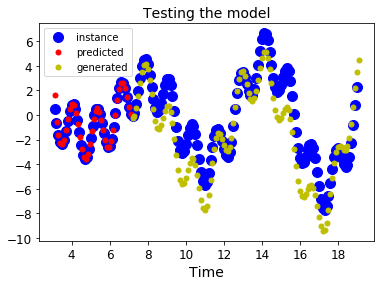

In [23]:
predict_and_generate("./CH14/models/creative_time_series_rnn_final.ckpt", 120, n_steps, beginning = 3.)

# LSTM

In [25]:
reset_graph()

n_steps = 40
n_inputs = 1
n_neurons = 100
n_outputs = 1

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs], name = "X")
y = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

with tf.name_scope("network"):
    basic_layer = tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
    rnn_output, states = tf.nn.dynamic_rnn(basic_layer, X, dtype=tf.float32)
    stacked_rnn_output = tf.reshape(rnn_output, [-1, n_neurons])
    stacked_output = tf.layers.dense(stacked_rnn_output, n_outputs)
    outputs = tf.reshape(stacked_output, [-1, n_steps, n_outputs], name = "outputs")

with tf.name_scope("loss"):
    loss = tf.reduce_mean(tf.square(outputs - y))
    
with tf.name_scope("trainer"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)


init= tf.global_variables_initializer()

saver = tf.train.Saver()

MSE_summary = tf.summary.scalar('Train_MSE', loss)

In [26]:
now = dt.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "./CH14/logs"
logdir = "{}/run-{}/".format(root_logdir, now)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 10 == 0 :
            mse_train_str = MSE_summary.eval(feed_dict = {X : X_batch, y : y_batch})
            file_writer.add_summary(mse_train_str, iteration)
    save_path = saver.save(sess,"./CH14/models/time_series_LSTM_final.ckpt")

INFO:tensorflow:Restoring parameters from ./CH14/models/time_series_LSTM_final.ckpt


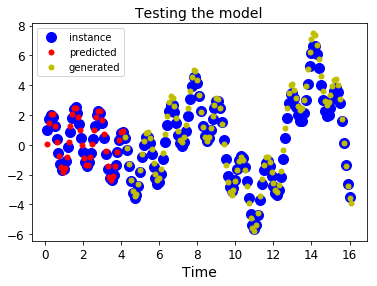

In [39]:
predict_and_generate("./CH14/models/time_series_LSTM_final.ckpt", 120, n_steps, beginning = 0.)

# GRU

In [28]:
reset_graph()

n_steps = 40
n_inputs = 1
n_neurons = 100
n_outputs = 1

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs], name = "X")
y = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

with tf.name_scope("network"):
    basic_layer = tf.contrib.rnn.GRUCell(num_units=n_neurons)
    rnn_output, states = tf.nn.dynamic_rnn(basic_layer, X, dtype=tf.float32)
    stacked_rnn_output = tf.reshape(rnn_output, [-1, n_neurons])
    stacked_output = tf.layers.dense(stacked_rnn_output, n_outputs)
    outputs = tf.reshape(stacked_output, [-1, n_steps, n_outputs], name = "outputs")

with tf.name_scope("loss"):
    loss = tf.reduce_mean(tf.square(outputs - y))
    
with tf.name_scope("trainer"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)


init= tf.global_variables_initializer()

saver = tf.train.Saver()

MSE_summary = tf.summary.scalar('Train_MSE', loss)

In [29]:
now = dt.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "./CH14/logs"
logdir = "{}/run-{}/".format(root_logdir, now)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 10 == 0 :
            mse_train_str = MSE_summary.eval(feed_dict = {X : X_batch, y : y_batch})
            file_writer.add_summary(mse_train_str, iteration)
    save_path = saver.save(sess,"./CH14/models/time_series_GRU_final.ckpt")

INFO:tensorflow:Restoring parameters from ./CH14/models/time_series_GRU_final.ckpt


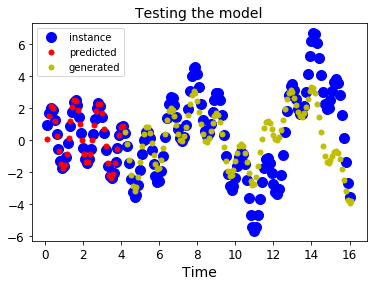

In [40]:
predict_and_generate("./CH14/models/time_series_GRU_final.ckpt", 120, n_steps, beginning = 0.)